# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [1]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [2]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(float(loss_sum / num_batches))

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz` if you don't already have it from A4. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [3]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [4]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cuda:0


In [5]:
len(np.unique(Ttrain))

10

adam: Epoch 2 Loss 0.507
adam: Epoch 4 Loss 0.288
adam: Epoch 6 Loss 0.238
adam: Epoch 8 Loss 0.215
adam: Epoch 10 Loss 0.198
adam: Epoch 12 Loss 0.181
adam: Epoch 14 Loss 0.177
adam: Epoch 16 Loss 0.170
adam: Epoch 18 Loss 0.163
adam: Epoch 20 Loss 0.158


Text(0.5, 1.0, 'MNIST')

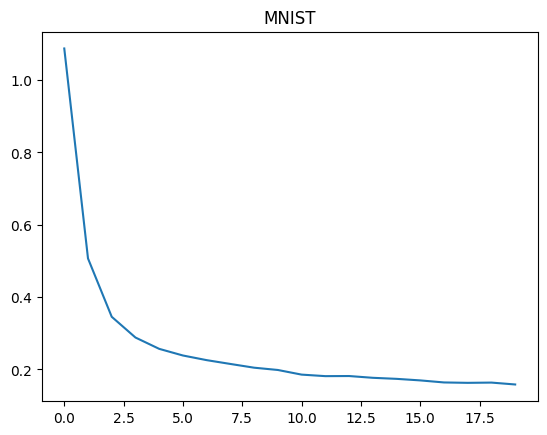

In [6]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

In [7]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [8]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 94.51


,0,1,2,3,4,5,6,7,8,9
0,95.816327,0.510204,1.020408,0.306122,0.000000,0.408163,1.530612,0.102041,0.306122,0.000000
1,0.264317,97.709251,0.264317,0.352423,0.088106,0.000000,0.352423,0.352423,0.616740,0.000000
2,1.550388,0.096899,93.701550,2.034884,0.484496,0.096899,0.096899,0.678295,1.162791,0.096899
3,0.198020,0.198020,1.188119,94.554455,0.000000,1.089109,0.000000,1.485149,0.891089,0.396040
4,0.101833,0.000000,0.305499,0.000000,96.130346,0.000000,0.814664,0.814664,0.203666,1.629328
5,0.336323,0.224215,0.336323,2.690583,0.224215,91.367713,1.345291,0.448430,2.690583,0.336323
6,1.565762,0.208768,0.208768,0.104384,0.521921,0.730689,96.137787,0.000000,0.521921,0.000000
7,0.194553,0.680934,1.167315,0.972763,0.778210,0.097276,0.097276,94.260700,0.097276,1.653696
8,0.410678,0.308008,0.924025,2.772074,0.410678,1.232033,0.924025,0.205339,91.889117,0.924025
9,0.396432,0.693756,0.495540,1.090188,2.180377,0.297324,0.396432,1.288404,0.297324,92.864222


### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each architecture, use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 1.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [9]:
results1 = []

### 1. CNN2D Nets with 1, 2, or 3 convolutional layers, each with 10 units and patch sizes of 1 and strides of 1

In [10]:
# Train CNN2D with 1 convolutional layer
cnnet1 = CNN2D(28 * 28, [10], [5], len(np.unique(Ttrain)), [5], [1], device=device)
cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.722
adam: Epoch 4 Loss 0.626
adam: Epoch 6 Loss 0.531
adam: Epoch 8 Loss 0.490
adam: Epoch 10 Loss 0.443
adam: Epoch 12 Loss 0.420
adam: Epoch 14 Loss 0.397
adam: Epoch 16 Loss 0.388
adam: Epoch 18 Loss 0.367
adam: Epoch 20 Loss 0.380


In [11]:
# Calculate accuracies from above CNN2D and store
train_classes, _ = cnnet1.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 1: {train_perc_correct:.2f}')

Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 1: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10]", "FC Arch": "[5]", "Parch Arch": "[5]", "Stride Arch": "[1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 1: 90.58
Test accuracy in percent correct for CNN 1: 90.82


In [12]:
# Train CNN2D with 2 convolutional layers
cnnet2 = CNN2D(28 * 28, [10, 10], [5], len(np.unique(Ttrain)), [5, 5], [1, 1], device=device)
cnnet2.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.609
adam: Epoch 4 Loss 0.422
adam: Epoch 6 Loss 0.359
adam: Epoch 8 Loss 0.355
adam: Epoch 10 Loss 0.319
adam: Epoch 12 Loss 0.334
adam: Epoch 14 Loss 0.311
adam: Epoch 16 Loss 0.316
adam: Epoch 18 Loss 0.306
adam: Epoch 20 Loss 0.303


In [13]:
# Calculate accuracies from above CNN2D and store
train_classes, _ = cnnet2.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 2: {train_perc_correct:.2f}')

Classes, _ = cnnet2.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 2: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10, 10]", "FC Arch": "[5]", "Parch Arch": "[5, 5]", "Stride Arch": "[1, 1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 2: 92.95
Test accuracy in percent correct for CNN 2: 93.19


In [14]:
# Train CNN2D with 3 convolutional layers
cnnet3 = CNN2D(28 * 28, [10, 10, 10], [5], len(np.unique(Ttrain)), [5, 5, 5], [1, 1, 1], device=device)
cnnet3.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.647
adam: Epoch 4 Loss 0.398
adam: Epoch 6 Loss 0.338
adam: Epoch 8 Loss 0.299
adam: Epoch 10 Loss 0.286
adam: Epoch 12 Loss 0.271
adam: Epoch 14 Loss 0.265
adam: Epoch 16 Loss 0.246
adam: Epoch 18 Loss 0.241
adam: Epoch 20 Loss 0.221


In [15]:
# Calculate accuracies from above CNN2D and store
train_classes, _ = cnnet3.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 3: {train_perc_correct:.2f}')

Classes, _ = cnnet3.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 3: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10, 10, 10]", "FC Arch": "[5]", "Parch Arch": "[5, 5, 5]", "Stride Arch": "[1, 1, 1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 3: 92.87
Test accuracy in percent correct for CNN 3: 93.18


### 2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.
The best performing model from those above was the one with 3 convolutional layers, so using that going forward

In [ ]:
# Train CNN2D with 0 FC Layers
cnnet4 = CNN2D(28 * 28, [10, 10, 10], [], len(np.unique(Ttrain)), [5, 5, 5], [1, 1, 1], device=device)
cnnet4.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.167
adam: Epoch 4 Loss 0.178
adam: Epoch 6 Loss 0.175
adam: Epoch 8 Loss 0.168
adam: Epoch 10 Loss 0.136
adam: Epoch 12 Loss 0.145
adam: Epoch 14 Loss 0.088
adam: Epoch 16 Loss 0.082
adam: Epoch 18 Loss 0.082
adam: Epoch 20 Loss 0.088


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1-2): 2 x Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=2560, out_features=10, bias=True)
  )
)

In [17]:
# Calculate accuracies from above model and store
train_classes, _ = cnnet4.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 4: {train_perc_correct:.2f}')

Classes, _ = cnnet4.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 4: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10, 10, 10]", "FC Arch": "[]", "Parch Arch": "[5, 5, 5]", "Stride Arch": "[1, 1, 1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 4: 98.82
Test accuracy in percent correct for CNN 4: 97.66


In [18]:
# Train CNN2D with 1 FC Layer
cnnet5 = CNN2D(28 * 28, [10, 10, 10], [10], len(np.unique(Ttrain)), [5, 5, 5], [1, 1, 1], device=device)
cnnet5.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.323
adam: Epoch 4 Loss 0.246
adam: Epoch 6 Loss 0.215
adam: Epoch 8 Loss 0.203
adam: Epoch 10 Loss 0.167
adam: Epoch 12 Loss 0.189
adam: Epoch 14 Loss 0.176
adam: Epoch 16 Loss 0.181
adam: Epoch 18 Loss 0.168
adam: Epoch 20 Loss 0.169


In [19]:
# Calculate accuracies from above model and store
train_classes, _ = cnnet5.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 5: {train_perc_correct:.2f}')

Classes, _ = cnnet5.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 5: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10, 10, 10]", "FC Arch": "[10]", "Parch Arch": "[5, 5, 5]", "Stride Arch": "[1, 1, 1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 5: 94.86
Test accuracy in percent correct for CNN 5: 95.17


In [20]:
# Train CNN2D with 3 FC Layers
cnnet6 = CNN2D(28 * 28, [10, 10, 10], [10, 10], len(np.unique(Ttrain)), [5, 5, 5], [1, 1, 1], device=device)
cnnet6.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.380
adam: Epoch 4 Loss 0.283
adam: Epoch 6 Loss 0.249
adam: Epoch 8 Loss 0.235
adam: Epoch 10 Loss 0.227
adam: Epoch 12 Loss 0.225
adam: Epoch 14 Loss 0.197
adam: Epoch 16 Loss 0.202
adam: Epoch 18 Loss 0.224
adam: Epoch 20 Loss 0.194


In [21]:
# Calculate accuracies for above model and store
train_classes, _ = cnnet6.use(Xtrain)
train_perc_correct = 100 * np.mean(train_classes == Ttrain)
print(f'Train accuracy in percent correct for CNN 6: {train_perc_correct:.2f}')

Classes, _ = cnnet6.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for CNN 6: {perc_correct:.2f}')
results1.append({"Conv Arch": "[10, 10, 10]", "FC Arch": "[10, 10, 10]", "Parch Arch": "[5, 5, 5]", "Stride Arch": "[1, 1, 1]", "Train Acc": f'{train_perc_correct:.2f}', "Test Acc": f'{perc_correct:.2f}'})

Train accuracy in percent correct for CNN 6: 94.57
Test accuracy in percent correct for CNN 6: 94.75


In [22]:
# Convert results into dataframe and display
df1 = pandas.DataFrame(results1, columns=["Conv Arch", "FC Arch", "Parch Arch", "Stride Arch", "Train Acc", "Test Acc"])
df1

,Conv Arch,FC Arch,Parch Arch,Stride Arch,Train Acc,Test Acc
0,[10],[5],[5],[1],90.58,90.82
1,"[10, 10]",[5],"[5, 5]","[1, 1]",92.95,93.19
2,"[10, 10, 10]",[5],"[5, 5, 5]","[1, 1, 1]",92.87,93.18
3,"[10, 10, 10]",[],"[5, 5, 5]","[1, 1, 1]",98.82,97.66
4,"[10, 10, 10]",[10],"[5, 5, 5]","[1, 1, 1]",94.86,95.17
5,"[10, 10, 10]","[10, 10, 10]","[5, 5, 5]","[1, 1, 1]",94.57,94.75


The CNN with 3 Convolutional Layers performed the best out of the first 3 models. It seems that 1 or 2 convolutional layers weren't enough to completely resolve features from the input data, so 3 convolutional layers performed better.

Interestingly, the CNN with 3 Conv Layers and no Fully Connected Layers performed the best out of every model on both the Train and Test sets. The Train and Test Accuracies for this model were very close, indicating that something about its structure interacting with this data resulted in a very well fit model that can generalize without overfitting to the Train data. It's possible that the introduction of an increasing number of FC Layers in the other models may be causing a loss of information or relationships within the data. It's also possible that the FC Layers introduce a vanishing/exploding gradient into the model that is harming the accuracy. However, all of the last 3 models performed better than any of the first 3 on both the Train and Test sets, indicating that the FC Layer architecture of a single layer of 5 units in the first 3 models may be particularly bad for this dataset.

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `make_conv_and_fc_layers` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately. `input_hw` refers to "input height width".  What would beed to change to make this make sense for a single dimensional sample?
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [23]:
class CNN1D(CNN2D):

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values long, with zeros between the waves.

In [24]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [25]:
square_pulse = make_square_pulse()
square_pulse

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

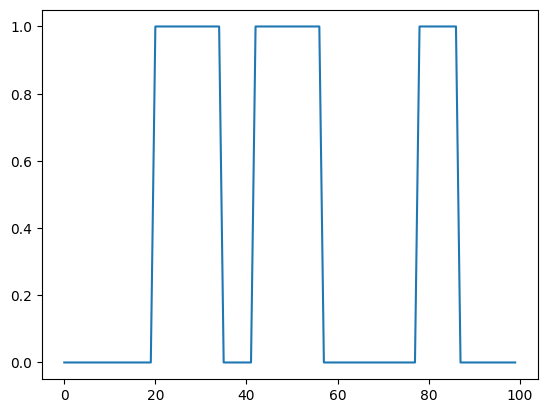

In [26]:
plt.plot(square_pulse)

In [27]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

In [28]:
triangular_pulse = make_triangular_pulse()
triangular_pulse

array([0.        , 0.5       , 1.        , 1.        , 0.5       ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16666667, 0.33333333, 0.5       , 0.66666667, 0.83333333,
       1.        , 1.        , 0.83333333, 0.66666667, 0.5       ,
       0.33333333, 0.16666667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444

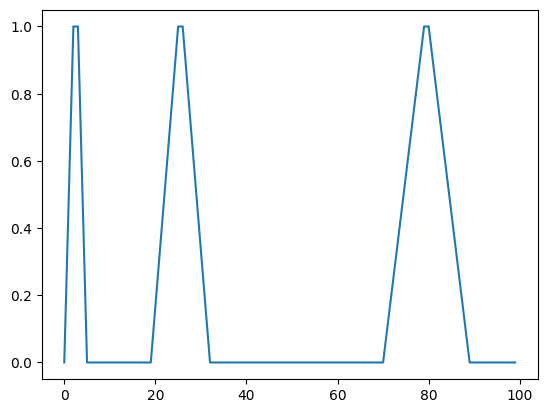

In [29]:
plt.plot(triangular_pulse)

In [30]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [31]:
np.newaxis == None

True

In [32]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [33]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.639
adam: Epoch 20 Loss 0.600
adam: Epoch 30 Loss 0.252
adam: Epoch 40 Loss 0.045
adam: Epoch 50 Loss 0.008
adam: Epoch 60 Loss 0.003
adam: Epoch 70 Loss 0.001
adam: Epoch 80 Loss 0.001
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

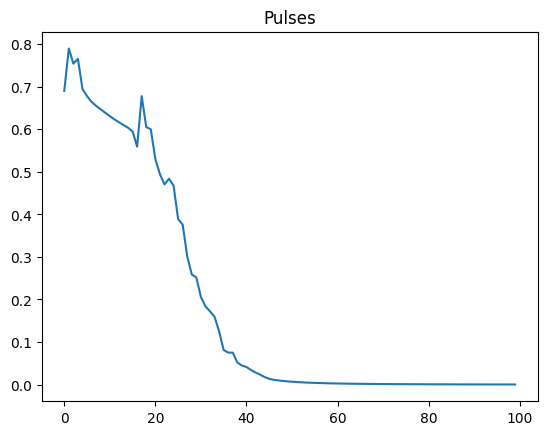

In [34]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [35]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 99.10


,square,triangular
square,98.2,1.8
triangular,0.0,100.0


torch.Size([10, 10])

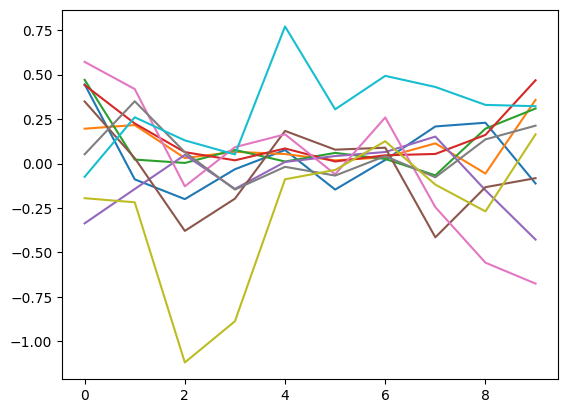

In [36]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [37]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

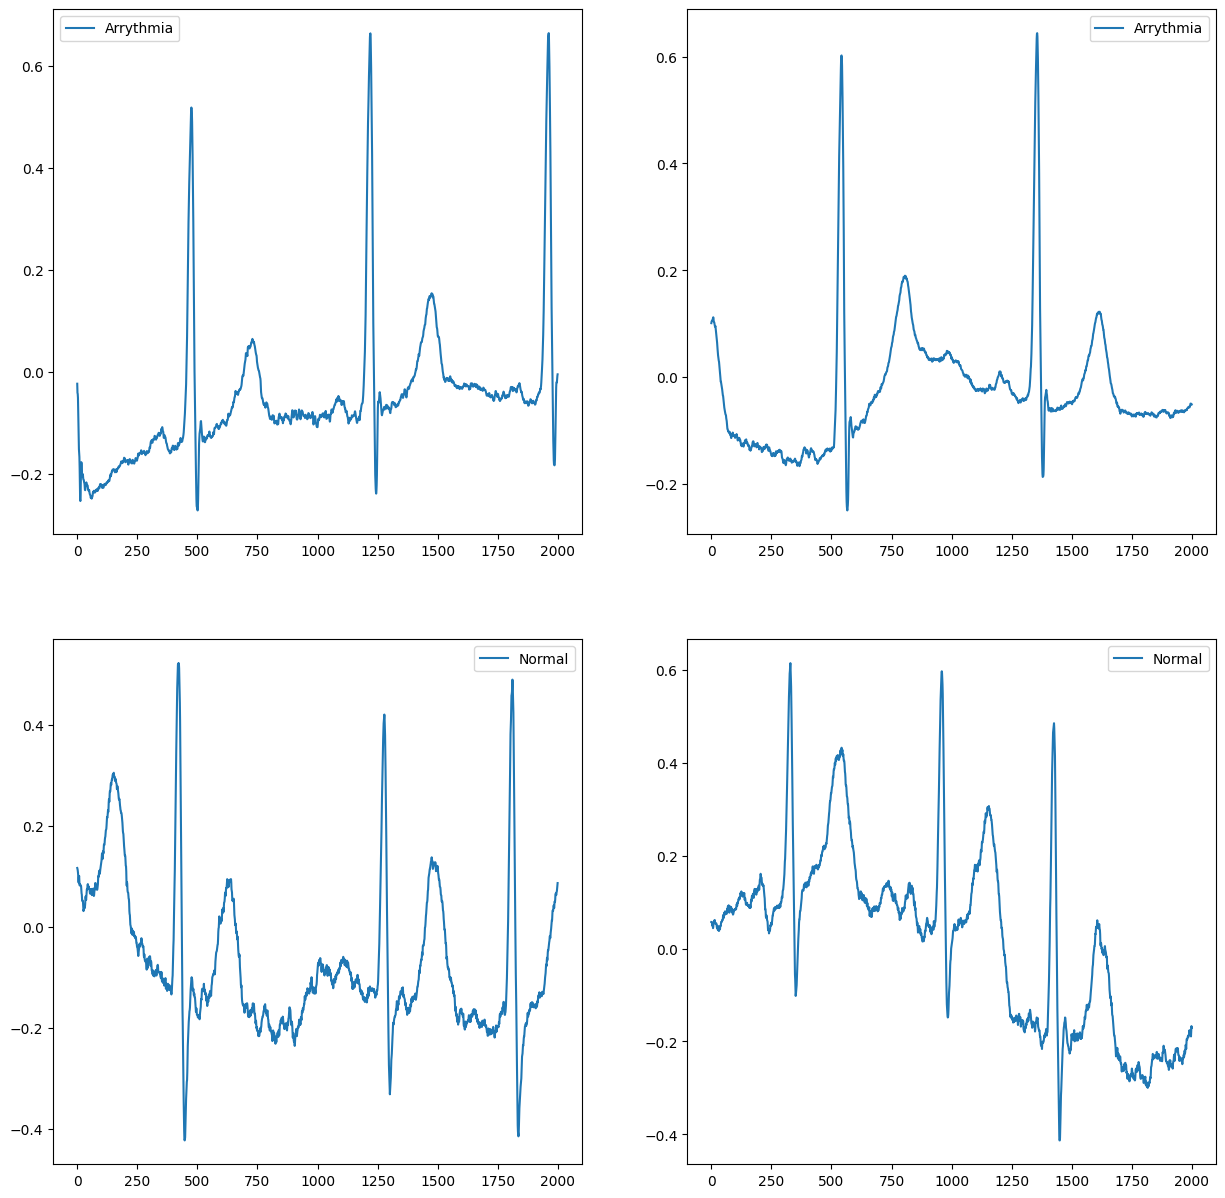

In [38]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [39]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [40]:
Ttrain

array([['nr'],
       ['nr'],
       ['nr'],
       ...,
       ['arr'],
       ['nr'],
       ['nr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [41]:
result = []

In [42]:
# Train CNN 1
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]

cnn1d1 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d1.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.349
adam: Epoch 20 Loss 0.183
adam: Epoch 30 Loss 0.091
adam: Epoch 40 Loss 0.069
adam: Epoch 50 Loss 0.059
adam: Epoch 60 Loss 0.038
adam: Epoch 70 Loss 0.048
adam: Epoch 80 Loss 0.005
adam: Epoch 90 Loss 0.001
adam: Epoch 100 Loss 0.000


In [43]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d1.use(Xtrain)
train_perc_correct1 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d1.use(Xtest)
test_perc_correct1 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct1:.2f}', "Test Accuracy": f'{test_perc_correct1:.2f}'})

In [44]:
# Train CNN 2
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [50, 10]
stride_per_conv_layer = [20, 5]

cnn1d2 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d2.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.555
adam: Epoch 20 Loss 0.465
adam: Epoch 30 Loss 0.358
adam: Epoch 40 Loss 0.272
adam: Epoch 50 Loss 0.216
adam: Epoch 60 Loss 0.170
adam: Epoch 70 Loss 0.151
adam: Epoch 80 Loss 0.140
adam: Epoch 90 Loss 0.114
adam: Epoch 100 Loss 0.106


In [45]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d2.use(Xtrain)
train_perc_correct2 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d2.use(Xtest)
test_perc_correct2 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct2:.2f}', "Test Accuracy": f'{test_perc_correct2:.2f}'})

In [46]:
# Train CNN 3
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [5, 2]

cnn1d3 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d3.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.331
adam: Epoch 20 Loss 0.238
adam: Epoch 30 Loss 0.166
adam: Epoch 40 Loss 0.147
adam: Epoch 50 Loss 0.114
adam: Epoch 60 Loss 0.095
adam: Epoch 70 Loss 0.077
adam: Epoch 80 Loss 0.119
adam: Epoch 90 Loss 0.066
adam: Epoch 100 Loss 0.081


In [47]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d3.use(Xtrain)
train_perc_correct3 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d3.use(Xtest)
test_perc_correct3 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct3:.2f}', "Test Accuracy": f'{test_perc_correct3:.2f}'})

In [48]:
# Train CNN 4
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [2, 2]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]

cnn1d4 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d4.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.443
adam: Epoch 20 Loss 0.356
adam: Epoch 30 Loss 0.124
adam: Epoch 40 Loss 0.090
adam: Epoch 50 Loss 0.070
adam: Epoch 60 Loss 0.057
adam: Epoch 70 Loss 0.037
adam: Epoch 80 Loss 0.048
adam: Epoch 90 Loss 0.034
adam: Epoch 100 Loss 0.037


In [49]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d4.use(Xtrain)
train_perc_correct4 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d4.use(Xtest)
test_perc_correct4 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct4:.2f}', "Test Accuracy": f'{test_perc_correct4:.2f}'})

In [50]:
# Train CNN 5
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [2, 2]
patch_size_per_conv_layer = [50, 10]
stride_per_conv_layer = [5, 2]

cnn1d5 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d5.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.527
adam: Epoch 20 Loss 0.494
adam: Epoch 30 Loss 0.471
adam: Epoch 40 Loss 0.448
adam: Epoch 50 Loss 0.427
adam: Epoch 60 Loss 0.414
adam: Epoch 70 Loss 0.407
adam: Epoch 80 Loss 0.400
adam: Epoch 90 Loss 0.381
adam: Epoch 100 Loss 0.373


In [51]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d5.use(Xtrain)
train_perc_correct5 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d5.use(Xtest)
test_perc_correct5 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct5:.2f}', "Test Accuracy": f'{test_perc_correct5:.2f}'})

In [52]:
# CNN 6
n_hiddens_per_conv_layer = [2, 5]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]

cnn1d6 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d6.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.478
adam: Epoch 20 Loss 0.333
adam: Epoch 30 Loss 0.248
adam: Epoch 40 Loss 0.200
adam: Epoch 50 Loss 0.174
adam: Epoch 60 Loss 0.157
adam: Epoch 70 Loss 0.142
adam: Epoch 80 Loss 0.162
adam: Epoch 90 Loss 0.138
adam: Epoch 100 Loss 0.124


In [53]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d6.use(Xtrain)
train_perc_correct6 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d6.use(Xtest)
test_perc_correct6 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct6:.2f}', "Test Accuracy": f'{test_perc_correct6:.2f}'})

In [54]:
# Train CNN 7
n_hiddens_per_conv_layer = [2, 5]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [50, 10]
stride_per_conv_layer = [20, 5]

cnn1d7 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d7.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.541
adam: Epoch 20 Loss 0.439
adam: Epoch 30 Loss 0.346
adam: Epoch 40 Loss 0.300
adam: Epoch 50 Loss 0.265
adam: Epoch 60 Loss 0.240
adam: Epoch 70 Loss 0.222
adam: Epoch 80 Loss 0.216
adam: Epoch 90 Loss 0.193
adam: Epoch 100 Loss 0.176


In [55]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d7.use(Xtrain)
train_perc_correct7 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d7.use(Xtest)
test_perc_correct7 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct7:.2f}', "Test Accuracy": f'{test_perc_correct7:.2f}'})

In [56]:
# CNN 8
n_hiddens_per_conv_layer = [2, 5]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [5, 2]

cnn1d8 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d8.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.375
adam: Epoch 20 Loss 0.258
adam: Epoch 30 Loss 0.202
adam: Epoch 40 Loss 0.167
adam: Epoch 50 Loss 0.146
adam: Epoch 60 Loss 0.126
adam: Epoch 70 Loss 0.102
adam: Epoch 80 Loss 0.085
adam: Epoch 90 Loss 0.091
adam: Epoch 100 Loss 0.085


In [57]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d8.use(Xtrain)
train_perc_correct8 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d8.use(Xtest)
test_perc_correct8 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct8:.2f}', "Test Accuracy": f'{test_perc_correct8:.2f}'})

In [58]:
# Train CNN 9
n_hiddens_per_conv_layer = [10, 20]
n_hiddens_per_fc_layer = [10, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]

cnn1d9 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d9.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.170
adam: Epoch 20 Loss 0.055
adam: Epoch 30 Loss 0.059
adam: Epoch 40 Loss 0.043
adam: Epoch 50 Loss 0.077
adam: Epoch 60 Loss 0.033
adam: Epoch 70 Loss 0.028
adam: Epoch 80 Loss 0.019
adam: Epoch 90 Loss 0.010
adam: Epoch 100 Loss 0.148


In [59]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d9.use(Xtrain)
train_perc_correct9 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d9.use(Xtest)
test_perc_correct9 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct9:.2f}', "Test Accuracy": f'{test_perc_correct9:.2f}'})

In [60]:
# CNN 10
n_hiddens_per_conv_layer = [5, 10]
n_hiddens_per_fc_layer = [20, 20]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [5, 2]

cnn1d0 = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)
cnn1d0.train(Xtrain, Ttrain, batch_size=10, n_epochs=100, learning_rate=0.001, method='adam');

adam: Epoch 10 Loss 0.275
adam: Epoch 20 Loss 0.174
adam: Epoch 30 Loss 0.125
adam: Epoch 40 Loss 0.122
adam: Epoch 50 Loss 0.074
adam: Epoch 60 Loss 0.080
adam: Epoch 70 Loss 0.088
adam: Epoch 80 Loss 0.088
adam: Epoch 90 Loss 0.027
adam: Epoch 100 Loss 0.061


In [61]:
# Calculate accuracies for above model and store
Classes, _ = cnn1d0.use(Xtrain)
train_perc_correct0 = 100 * np.mean(Classes == Ttrain)

Classes, _ = cnn1d0.use(Xtest)
test_perc_correct0 = 100 * np.mean(Classes == Ttest)
result.append({"Hiddens / Layer": n_hiddens_per_conv_layer, "Hiddens / FC Layer": n_hiddens_per_fc_layer, 
               "Patch Size / Conv Layer": patch_size_per_conv_layer, "Stride / Conv Layer": stride_per_conv_layer, 
               "Train Accuracy": f'{train_perc_correct0:.2f}', "Test Accuracy": f'{test_perc_correct0:.2f}'})

In [64]:
df = pandas.DataFrame(result, columns=['Hiddens / Layer', "Hiddens / FC Layer", "Patch Size / Conv Layer", "Stride / Conv Layer", 'Train Accuracy', 'Test Accuracy'])
df

,Hiddens / Layer,Hiddens / FC Layer,Patch Size / Conv Layer,Stride / Conv Layer,Train Accuracy,Test Accuracy
0,"[5, 10]","[10, 10]","[100, 20]","[20, 5]",99.96,89.69
1,"[5, 10]","[10, 10]","[50, 10]","[20, 5]",93.57,77.00
2,"[5, 10]","[10, 10]","[100, 20]","[5, 2]",97.67,84.58
3,"[5, 10]","[2, 2]","[100, 20]","[20, 5]",97.03,93.24
4,"[5, 10]","[2, 2]","[50, 10]","[5, 2]",85.44,74.11
5,"[2, 5]","[10, 10]","[100, 20]","[20, 5]",93.90,82.77
6,"[2, 5]","[10, 10]","[50, 10]","[20, 5]",92.06,80.96
7,"[2, 5]","[10, 10]","[100, 20]","[5, 2]",94.87,74.77
8,"[10, 20]","[10, 10]","[100, 20]","[20, 5]",97.38,90.85
9,"[5, 10]","[20, 20]","[100, 20]","[5, 2]",98.12,84.67


The network structure and training parameters that produced the best test results was the network with Hiddens / Layer: [5, 10], Hiddens / FC Layer: [2, 2], Patch Size: [100, 20], Stride: [20, 5] with a test accuracy of 93.24%. The larger number of Hiddens / Layer allows for a better capacity to learn patterns, and the Hiddens / FC Layer is small, which creates a data bottleneck and forces the features to be more generalized, which causes the model to transfer between datasets more effectively. This is supported by the fact that this model did NOT have the highest Train Accuracy despite its high Test Accuracy.

A close second was the network the same as above but with Hiddens / FC Layer: [2, 2], with 89.04%. This may be due to the low number of fully connected neurons and the large patch sizes/strides acted as a bottleneck in the network, forcing very generalized representations of the data. This may have resulted in a better transitions between training data and test data, and therefore higher test accuracy. The higher number of Hiddens / Layer resulted in a slight increase in the accuracy, but nothing significant.

Perhaps the greatest victim of overfitting in this set was CNN ID 7, with 94.87% Train Accuracy, but only 74.77% Test Accuracy. This implies that the low number of units in the Convolutional Layers compared to those in the FC Layers caused some issues in generalizing the data. When you look at all 3 models with that Conv Layer / FC Layer architecture, they all showcase similar drops in Test Accuracy, which supports this conclusion.

Overall, a larger patch size resulted in higher accuracy. This is likely because a smaller patch size can't capture features as effectively as larger patch sizes. Strides seems to have a much lower impact on the overall accuracy, with a lower stride resulting in slightly lower accuracy. This could be due to such a low stride resulting in overfitting to the train data.

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [65]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Tone-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1d.us

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.

In [66]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [77]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet_tanh = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function="tanh", device=device)

cnnet_relu = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function="relu", device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet_tanh.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');
cnnet_relu.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

adam: Epoch 2 Loss 0.419
adam: Epoch 4 Loss 0.277
adam: Epoch 6 Loss 0.233
adam: Epoch 8 Loss 0.211
adam: Epoch 10 Loss 0.195
adam: Epoch 12 Loss 0.182
adam: Epoch 14 Loss 0.175
adam: Epoch 16 Loss 0.169
adam: Epoch 18 Loss 0.160
adam: Epoch 20 Loss 0.161
adam: Epoch 2 Loss 0.359
adam: Epoch 4 Loss 0.194
adam: Epoch 6 Loss 0.147
adam: Epoch 8 Loss 0.127
adam: Epoch 10 Loss 0.114
adam: Epoch 12 Loss 0.103
adam: Epoch 14 Loss 0.098
adam: Epoch 16 Loss 0.093
adam: Epoch 18 Loss 0.086
adam: Epoch 20 Loss 0.085


In [80]:
Classes_tanh, _ = cnnet_tanh.use(Xtest)
tanh_perc_correct = 100 * np.mean(Classes_tanh == Ttest)
print(f'(Tanh) Test accuracy in percent correct: {tanh_perc_correct:.2f}')
confusion_matrix(Classes_tanh, Ttest)

(Tanh) Test accuracy in percent correct: 94.05


,0,1,2,3,4,5,6,7,8,9
0,97.346939,0.000000,0.306122,0.102041,0.204082,0.204082,0.918367,0.000000,0.918367,0.000000
1,0.000000,98.678414,0.088106,0.264317,0.088106,0.088106,0.264317,0.088106,0.352423,0.088106
2,0.968992,0.387597,91.279070,2.810078,0.484496,0.000000,0.775194,1.065891,2.131783,0.096899
3,0.099010,0.198020,0.990099,94.653465,0.000000,1.089109,0.000000,1.287129,1.089109,0.594059
4,0.101833,0.509165,0.203666,0.101833,95.315682,0.000000,1.018330,0.509165,0.101833,2.138493
5,0.784753,0.112108,0.000000,1.569507,0.112108,92.376682,1.345291,0.000000,2.690583,1.008969
6,0.835073,0.626305,0.104384,0.000000,1.252610,0.939457,95.824635,0.000000,0.313152,0.104384
7,0.291829,0.680934,1.459144,0.680934,0.583658,0.291829,0.000000,93.871595,0.389105,1.750973
8,0.718686,1.129363,0.821355,1.642710,0.102669,2.977413,1.129363,0.924025,90.041068,0.513347
9,0.594648,0.991080,0.099108,0.297324,3.468781,1.783944,0.000000,2.279485,0.000000,90.485629


In [81]:
Classes_relu, _ = cnnet_relu.use(Xtest)
relu_perc_correct = 100 * np.mean(Classes_relu == Ttest)
print(f'(RELU) Test accuracy in percent correct: {relu_perc_correct:.2f}')
confusion_matrix(Classes_relu, Ttest)

(RELU) Test accuracy in percent correct: 96.31


,0,1,2,3,4,5,6,7,8,9
0,97.857143,0.000000,0.102041,0.000000,0.000000,0.204082,0.918367,0.714286,0.204082,0.000000
1,0.088106,98.942731,0.440529,0.264317,0.000000,0.000000,0.000000,0.088106,0.176211,0.000000
2,0.872093,0.193798,93.507752,2.325581,0.000000,0.290698,0.000000,0.968992,1.841085,0.000000
3,0.000000,0.099010,0.297030,97.722772,0.000000,0.495050,0.000000,0.693069,0.396040,0.297030
4,0.000000,0.101833,0.101833,0.000000,98.065173,0.000000,0.203666,0.610998,0.509165,0.407332
5,0.448430,0.000000,0.112108,1.681614,0.000000,94.618834,1.008969,0.224215,1.681614,0.224215
6,0.835073,0.208768,0.000000,0.000000,0.626305,0.104384,97.599165,0.000000,0.626305,0.000000
7,0.291829,0.194553,0.583658,0.486381,0.291829,0.000000,0.000000,97.178988,0.194553,0.778210
8,0.308008,0.102669,0.616016,1.232033,0.308008,0.000000,0.410678,0.205339,96.303901,0.513347
9,0.198216,0.495540,0.099108,0.991080,3.171457,1.387512,0.099108,1.189296,1.387512,90.981169


RELU showed a slightly higher accuracy on the MNIST data than Tanh, with 96.31% Test Acc vs 94.05% Test Acc. RELU also showed a much higher occurrence of 0% incorrect letter picks in the confusion matrix, along with overall lower incorrect pick rates. The loss of the RELU model also ended at nearly half that of the Tanh model in epoch 20. This could be due to a few different causes. One of them is that RELU avoids vanishing gradients, which could reduce any stalling in the model and increase the speed on convergence on an accurate set of weights.

2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.

In [88]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet_ec = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function="relu", device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

In [89]:
cnnet_ec.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam');

Classes_ec, _ = cnnet_ec.use(Xtest)
ec_perc_correct = 100 * np.mean(Classes_ec == Ttest)
print(f'Test accuracy in percent correct: {ec_perc_correct:.2f}')
confusion_matrix(Classes_ec, Ttest)

adam: Epoch 2 Loss 0.326
adam: Epoch 4 Loss 0.202
adam: Epoch 6 Loss 0.170
adam: Epoch 8 Loss 0.155
adam: Epoch 10 Loss 0.140
adam: Epoch 12 Loss 0.124
adam: Epoch 14 Loss 0.110
adam: Epoch 16 Loss 0.103
adam: Epoch 18 Loss 0.099
adam: Epoch 20 Loss 0.094
Test accuracy in percent correct: 96.34


,0,1,2,3,4,5,6,7,8,9
0,97.244898,0.000000,0.306122,0.000000,0.000000,0.306122,1.326531,0.510204,0.306122,0.000000
1,0.000000,98.325991,0.792952,0.088106,0.000000,0.000000,0.352423,0.088106,0.352423,0.000000
2,0.193798,0.096899,96.996124,1.162791,0.000000,0.193798,0.387597,0.678295,0.290698,0.000000
3,0.000000,0.000000,0.792079,97.821782,0.000000,0.594059,0.000000,0.396040,0.297030,0.099010
4,0.000000,0.203666,0.203666,0.000000,96.741344,0.000000,0.712831,0.203666,0.101833,1.832994
5,0.112108,0.000000,0.224215,3.475336,0.000000,93.497758,1.008969,0.112108,1.233184,0.336323
6,0.521921,0.104384,0.417537,0.000000,0.208768,0.104384,98.643006,0.000000,0.000000,0.000000
7,0.291829,0.389105,1.945525,0.972763,0.291829,0.194553,0.000000,94.552529,0.194553,1.167315
8,0.000000,0.205339,0.718686,1.334702,0.513347,0.513347,0.821355,0.308008,94.969199,0.616016
9,0.198216,0.396432,0.000000,1.684836,1.486620,0.594648,0.198216,0.891972,0.396432,94.152626


In [90]:
cnnet_ec.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='sgd');

Classes_ec, _ = cnnet_ec.use(Xtest)
ec_perc_correct = 100 * np.mean(Classes_ec == Ttest)
print(f'Test accuracy in percent correct: {ec_perc_correct:.2f}')
confusion_matrix(Classes_ec, Ttest)

sgd: Epoch 2 Loss 0.076
sgd: Epoch 4 Loss 0.073
sgd: Epoch 6 Loss 0.072
sgd: Epoch 8 Loss 0.070
sgd: Epoch 10 Loss 0.069
sgd: Epoch 12 Loss 0.068
sgd: Epoch 14 Loss 0.068
sgd: Epoch 16 Loss 0.067
sgd: Epoch 18 Loss 0.066
sgd: Epoch 20 Loss 0.066
Test accuracy in percent correct: 96.93


,0,1,2,3,4,5,6,7,8,9
0,98.877551,0.000000,0.000000,0.000000,0.000000,0.306122,0.204082,0.306122,0.306122,0.000000
1,0.088106,98.502203,0.704846,0.000000,0.000000,0.000000,0.264317,0.176211,0.264317,0.000000
2,0.387597,0.193798,97.577519,0.484496,0.096899,0.096899,0.290698,0.581395,0.290698,0.000000
3,0.000000,0.000000,1.386139,96.336634,0.000000,0.990099,0.000000,0.495050,0.693069,0.099010
4,0.000000,0.203666,0.000000,0.000000,98.065173,0.000000,0.509165,0.203666,0.000000,1.018330
5,0.336323,0.000000,0.000000,1.457399,0.000000,95.515695,0.560538,0.112108,1.569507,0.448430
6,0.835073,0.104384,0.417537,0.000000,0.835073,0.104384,97.494781,0.000000,0.208768,0.000000
7,0.194553,0.389105,1.556420,0.389105,0.389105,0.194553,0.000000,96.108949,0.097276,0.680934
8,0.102669,0.102669,0.308008,0.102669,0.513347,0.410678,0.513347,0.308008,97.330595,0.308008
9,0.198216,0.396432,0.000000,1.288404,2.081269,0.594648,0.198216,1.486620,0.495540,93.260654


SGD appeared to perform slightly better than Adam, with a Test Acc of 96.93% vs 96.34%. This could be due to SGD having better generalization capabilities than Adam, which is vulnerable to overfitting on simple datasets like MNIST where Adam's individual learning rates may be too much. On a less simple/clean/organized dataset, Adam's flexibility may result in a better performance, but a simple dataset like MNIST may be most effectively modeled using more set models like SGD.